# Unet + SAM
### UNET version:
- 3-Channel version: DWI, ADC and b0
- Trained on JAG

### SAM version:
- 3-Channel version: DWI, ADC and DifDif_maps
- Original version of SAM

In [1]:
import sys
sys.path.append('../../')

# Loads all methods and data for testing
from Performance.methods_for_testing_Unet import *

/home/rosengaard/miniforge3/envs/medsam3.9/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
channels = 3
model_path = '/home/rosengaard/mri-infarct-segmentation/Anders/V3/Unet_C3/JAG/weights/Unet_C3_model700.pt'
trained_on_dataset = "JAG"
type = "test"

In [3]:
# Load model
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
m_state_dict = torch.load(model_path, map_location=torch.device(device))
model = UNet(n_class=1, n_channels=channels).to(device)
if torch.cuda.device_count() > 1:
    model = nn.DataParallel(model)
model.load_state_dict(m_state_dict)

# Load data
test_data_path = os.path.join(current_directory, 'mri-infarct-segmentation/data/DUPONT/datasplit/FixedPath/test_data.csv')
testDataset = CustomDataset(test_data_path, channels, type)
testDataLoader = torch.utils.data.DataLoader(testDataset,
                                            batch_size=1,
                                            shuffle=False,
                                            num_workers = 0
                                            )

In [5]:
def get_bounding_box(input_vol):
    # Resized volumes to match original dimentions:
    vol_dim = (256, 256, 22) #volumes are resized to the same dimention
    input_vol = skTrans.resize(input_vol, vol_dim, order=1, preserve_range=True)

    bbox_vol = []
    for slice_idx in range(0,len(input_vol[0,2])):
        input_slice = input_vol[:,:,slice_idx] > 0.5
        if np.sum(input_slice) > 0:
            y_indices, x_indices = np.where(input_slice > 0)
            x_min, x_max = np.min(x_indices), np.max(x_indices)
            y_min, y_max = np.min(y_indices), np.max(y_indices)
            H, W = input_slice.shape

            # Add padding to bbox buffer to bounding box:
            pad = 2
            x_min = x_min - pad
            x_max = x_max + pad
            y_min = y_min - pad
            y_max = y_max + pad
            bbox = [x_min, y_min, x_max, y_max]
        else:
            bbox = [0,0,0,0]
        bbox_vol.append(bbox)

    return bbox_vol

In [6]:
#Run UNet to create Bboxes:
prompts_from_Unet = []
i = 0
for x_val, yval in testDataLoader:
    print("Subject:",i+1, "of", len(testDataLoader))
    i += 1
    with torch.cuda.amp.autocast():
        output = model(x_val.to(device))
    torch.cuda.empty_cache()
    
    model_segmentation = np.transpose(output[0,0,:,:,:].cpu().detach().numpy(), (0, 1, 2))
    
    # Get the bounding_box to prompt SAM:
    bbox = get_bounding_box(np.asarray(model_segmentation))
    prompts_from_Unet.append(bbox)

Subject: 1 of 8


/home/rosengaard/miniforge3/envs/medsam3.9/lib/python3.9/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Subject: 2 of 8
Subject: 3 of 8
Subject: 4 of 8
Subject: 5 of 8
Subject: 6 of 8
Subject: 7 of 8
Subject: 8 of 8


# Setup of SAM

In [9]:
import tensorflow as tf
from transformers import SamProcessor
from transformers import SamModel
from transformers import SamModel, SamConfig, SamProcessor
from segment_anything import sam_model_registry
from segment_anything.modeling import (ImageEncoderViT, MaskDecoder, PromptEncoder, Sam, TwoWayTransformer)
from datasets import Dataset as _Dataset
from functools import partial
from dipy.align.imaffine import AffineRegistration
from dipy.align.transforms import AffineTransform3D

affreg = AffineRegistration(level_iters=[0])
current_directory = os.environ['HOME']

def Create_DWI_symDif_map(DWI_vol):
    # Mirror the image horizontally
    DWI_vol_mir = np.flipud(DWI_vol)

    # Register DWI_vol to mirrored DWI
    affine3d = affreg.optimize(DWI_vol, DWI_vol_mir, AffineTransform3D(), params0=None) 

    # Transform the mirrored DWI to match the original DWI_vol
    DWI_vol_trans = affine3d.transform(DWI_vol_mir)

    # Left/Right difference for DWI_vol:
    DWI_symDif_vol = DWI_vol-DWI_vol_trans

    return DWI_symDif_vol

def Create3ChannelVolumes(DWI_vol, ADC_vol, b0_vol, symDif_vol):
    DWI_slice = DWI_vol
    DWI_slice = ((DWI_slice - np.min(DWI_slice)) / (np.max(DWI_slice) - np.min(DWI_slice))).astype(float)

    # Compute the symmetric difference of left and right hemisphere from DWI:
    Sym_dif_slice = symDif_vol
    Sym_dif_slice = ((Sym_dif_slice - np.min(Sym_dif_slice)) / (np.max(Sym_dif_slice) - np.min(Sym_dif_slice))).astype(float)
    Sym_dif_slice = np.where(((Sym_dif_slice*-1+1) < DWI_slice), DWI_slice, DWI_slice*0.5)

    # Compute the difference between the modalities ADC and b0:
    b0_th = np.where(DWI_slice > (np.mean(DWI_slice)), b0_vol, 0)
    ADC_th = np.where(DWI_slice > (np.mean(DWI_slice)), ADC_vol, 0)
    modalityDif_slice = np.where(b0_th > ADC_th , DWI_slice, DWI_slice * 0.5)
    
    # Compute a dif_dif slice based on the difference between the to dif_slices:
    dif_dif_map = Sym_dif_slice * modalityDif_slice

    # Stack slices into 3-channel slice:
    DWI_vol = np.expand_dims(DWI_vol, axis=0)
    ADC_vol = np.expand_dims(ADC_vol, axis=0)
    C3_vol = np.concatenate((DWI_vol, ADC_vol), axis=0)
    dif_dif_vol = np.asarray(dif_dif_map)
    dif_dif_vol = ((dif_dif_vol - dif_dif_vol.min()) / (dif_dif_vol.max() - dif_dif_vol.min()) * 255).astype(np.uint8)
    dif_dif_vol = np.expand_dims(dif_dif_vol, axis=0)
    C3_vol = np.concatenate((C3_vol, dif_dif_vol), axis=0)

    return C3_vol

def getVolume(DWI_path, ADC_path, b0_path, label_path, bboxes):
    DWI_vol = nib.load(DWI_path).get_fdata()
    DWI_vol = ((DWI_vol - DWI_vol.min()) / (DWI_vol.max() - DWI_vol.min()) * 255).astype(np.uint8)
    
    symDif_vol = Create_DWI_symDif_map(DWI_vol)

    DWI_vol = DWI_vol.transpose(2, 0, 1)
    symDif_vol = symDif_vol.transpose(2, 0, 1)
  
    ADC_vol = nib.load(ADC_path).get_fdata()
    ADC_vol = ((ADC_vol - ADC_vol.min()) / (ADC_vol.max() - ADC_vol.min()) * 255).astype(np.uint8)
    ADC_vol = ADC_vol.transpose(2, 0, 1)

    b0_vol = nib.load(b0_path).get_fdata()
    b0_vol = ((b0_vol - b0_vol.min()) / (b0_vol.max() - b0_vol.min()) * 255).astype(np.uint8)
    b0_vol = b0_vol.transpose(2, 0, 1)
    
    label_vol = nib.load(label_path).get_fdata()
    masks = label_vol.transpose(2, 0, 1)

    #Create a list to store the indices of non-empty prompts
    valid_indices = [i for i, bbox in enumerate(bboxes) if max(bbox) != 0]
            
    # Filter the image and mask arrays to keep only the non-empty pairs
    DWI_vol = DWI_vol[valid_indices]
    ADC_vol = ADC_vol[valid_indices]
    b0_vol = b0_vol[valid_indices]
    symDif_vol = symDif_vol[valid_indices]
    filtered_masks = masks[valid_indices]

    # Convert the NumPy arrays to Pillow images and store them in a dictionary
    dataset_dict = {"DWI_vol": [Image.fromarray(img) for img in DWI_vol],
                    "ADC_vol": [Image.fromarray(img) for img in ADC_vol],
                    "b0_vol": [Image.fromarray(img) for img in b0_vol],
                    "symDif_vol": [Image.fromarray(img) for img in symDif_vol],
                    "label": [Image.fromarray(mask) for mask in filtered_masks],
                    "valid_indices": valid_indices,
    }

    # Create the dataset using the datasets.Dataset class
    return _Dataset.from_dict(dataset_dict)

class SAMDataset(Dataset):
  """
  This class is used to create a dataset that serves input images and masks.
  It takes a dataset and a processor as input and overrides the __len__ and __getitem__ methods of the Dataset class.
  """
  def __init__(self, dataset, processor, type, prompt):
    self.dataset = dataset
    self.processor = processor
    self.type = type
    self.prompt = prompt

  def __len__(self):
    return len(self.dataset)

  def __getitem__(self, idx):
    item = self.dataset[idx]
    DWI_vol = item["DWI_vol"]
    ADC_vol = item["ADC_vol"]
    b0_vol = item["b0_vol"]
    symDif_vol = item["symDif_vol"]
    ground_truth_mask = np.array(item["label"])
    valid_indices = np.array(item["valid_indices"])

    # get bounding box prompt
    prompt = self.prompt

    DWI_vol = np.array(DWI_vol)
    ADC_vol = np.array(ADC_vol)
    b0_vol = np.array(b0_vol)
    image = Create3ChannelVolumes(DWI_vol, ADC_vol, b0_vol, symDif_vol)

    # prepare image and prompt for the model
    inputs = self.processor(image, input_boxes=[[prompt]], return_tensors="pt")

    # remove batch dimension which the processor adds by default
    inputs = {k:v.squeeze(0) for k,v in inputs.items()}

    # add ground truth segmentation
    inputs["ground_truth_mask"] = ground_truth_mask
    inputs["valid_indices"] = valid_indices

    return inputs

def plotFunc(DWI_slice, modelout, Label_slice):
    fig, axes = plt.subplots(1, 3, figsize=(7, 7))
    axes[0].imshow(DWI_slice, cmap='gray')
    axes[0].set_title('DWI slice')
    axes[0].axes.axis('off')
    axes[1].imshow(modelout, cmap='gray')
    axes[1].set_title('SAM output')
    axes[1].axes.axis('off')
    axes[2].imshow(Label_slice, cmap='gray')
    axes[2].set_title('Label slice')
    axes[2].axes.axis('off')
    plt.show()

#Load data
test_data_path = os.path.join(current_directory, 'mri-infarct-segmentation/data/DUPONT/datasplit/FixedPath/test_data.csv')
df_test = pd.read_csv(test_data_path)
data = []
for i in range(0, len(df_test)):
    data.append([os.path.join(current_directory, df_test["DWI_path"][i]),
                os.path.join(current_directory, df_test["ADC_path"][i]),
                os.path.join(current_directory, df_test["b0"][i]),
                os.path.join(current_directory, df_test["Label_path"][i])])
    
# Load model and processor:
model = SamModel.from_pretrained("facebook/sam-vit-base") # Load the model
processor = SamProcessor.from_pretrained("facebook/sam-vit-base") # Initialize the processor

if torch.cuda.is_available():
    device = "cuda:0"
else:
    device = "cpu"
model.to(device)
if torch.cuda.device_count() > 1:
    model = nn.DataParallel(model)
print('Device:',device, ':',torch.cuda.device_count())

Device: cpu : 0


Volume: 1 of 8
Optimizing level 0 [max iter: 0]


100%|██████████| 7/7 [00:21<00:00,  3.02s/it]

0
Dice for slice: 0.0


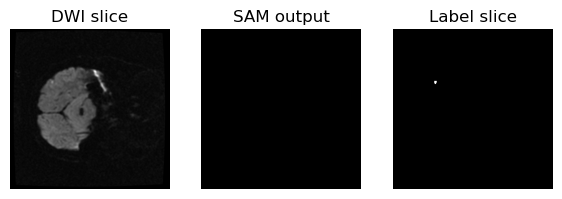

0
Dice for slice: 0.0


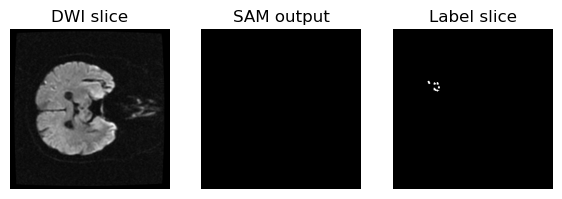

264
Dice for slice: 0.772


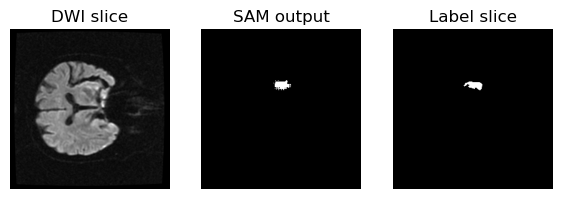

721
Dice for slice: 0.779


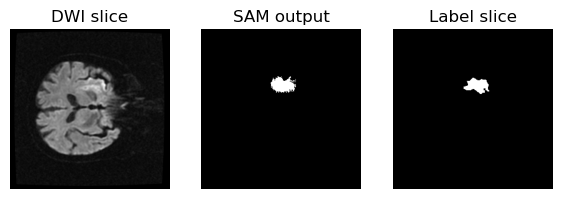

1095
Dice for slice: 0.645


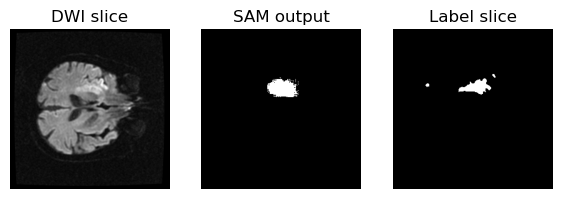

1181
Dice for slice: 0.607


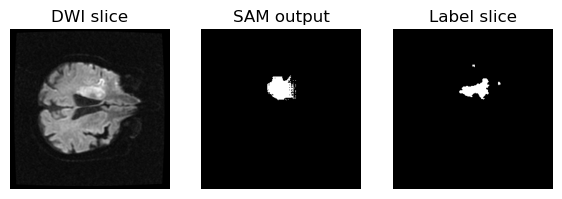

1129
Dice for slice: 0.467


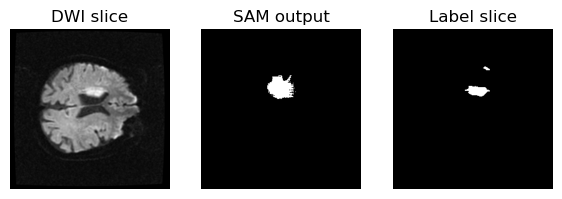

789
Dice for slice: 0.062


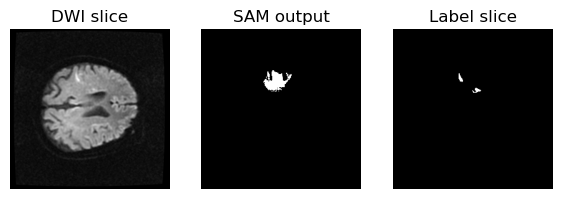

31
Dice for slice: 0.268


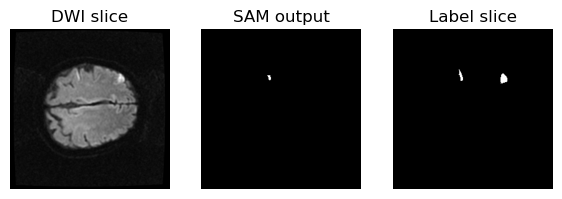

0
Dice for slice: 0.0


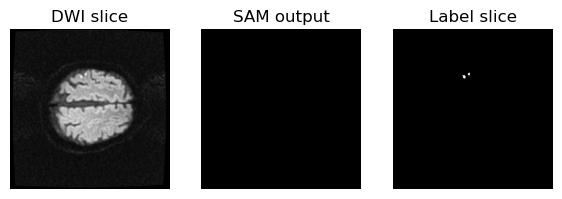

Mean slice dice for subject: 0.36
Volume dice for subject: 0.552
__________________________________
Volume: 2 of 8
Optimizing level 0 [max iter: 0]


100%|██████████| 3/3 [00:08<00:00,  2.99s/it]


208
Dice for slice: 0.696


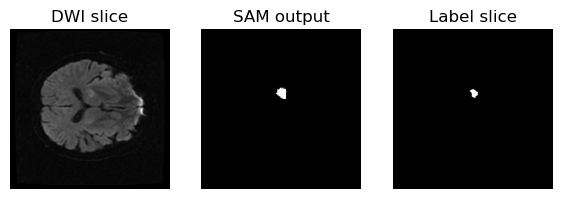

66
Dice for slice: 0


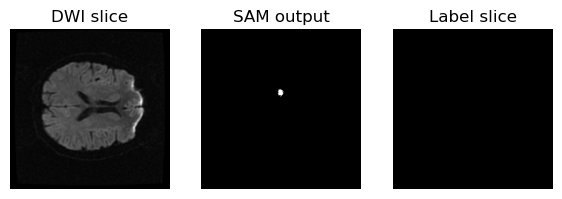

Mean slice dice for subject: 0.348
Volume dice for subject: 0.577
__________________________________
Volume: 3 of 8
Optimizing level 0 [max iter: 0]


100%|██████████| 9/9 [00:25<00:00,  2.78s/it]


406
Dice for slice: 0.471


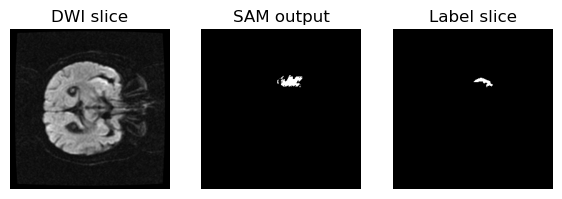

702
Dice for slice: 0.583


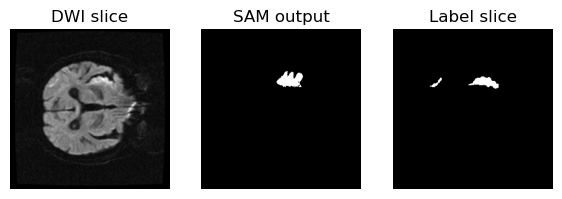

680
Dice for slice: 0.558


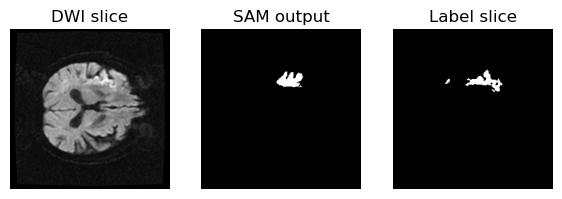

748
Dice for slice: 0.572


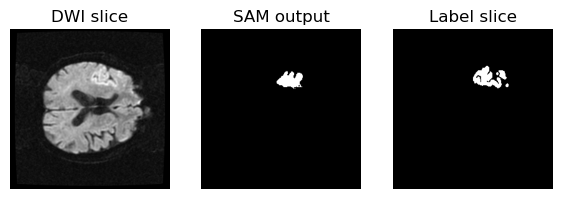

917
Dice for slice: 0.151


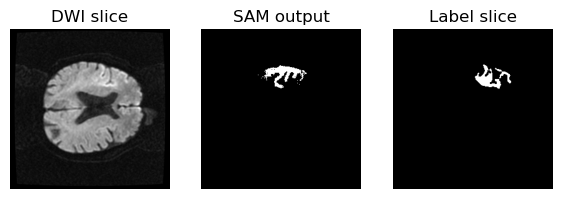

840
Dice for slice: 0.127


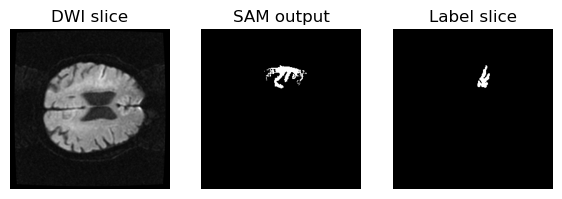

891
Dice for slice: 0.208


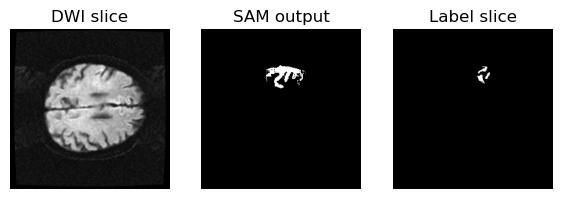

199
Dice for slice: 0.0


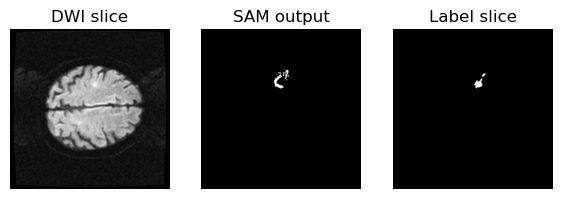

95
Dice for slice: 0.674


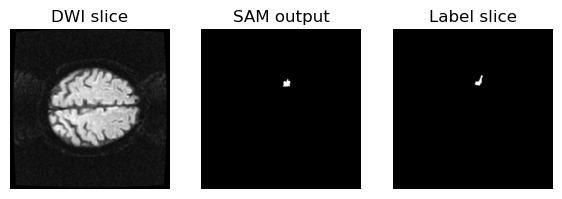

0
Dice for slice: 0.0


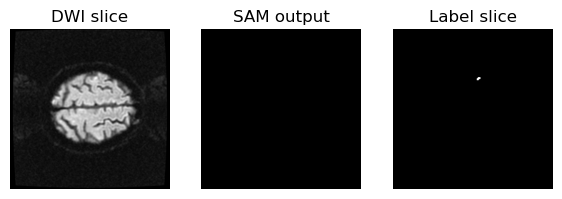

Mean slice dice for subject: 0.334
Volume dice for subject: 0.374
__________________________________
Volume: 4 of 8
Optimizing level 0 [max iter: 0]


100%|██████████| 10/10 [00:32<00:00,  3.21s/it]

155
Dice for slice: 0.754


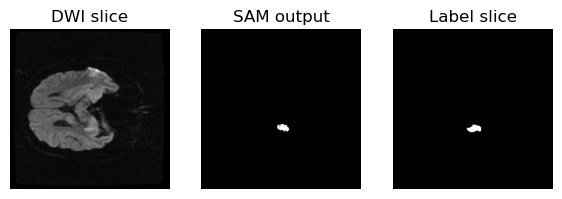

666
Dice for slice: 0.507


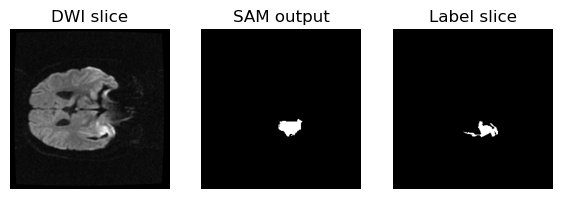

464
Dice for slice: 0.261


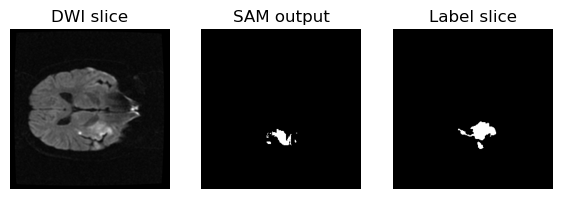

507
Dice for slice: 0.329


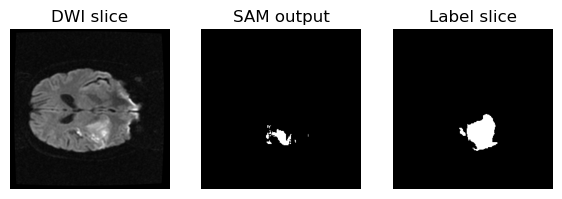

422
Dice for slice: 0.287


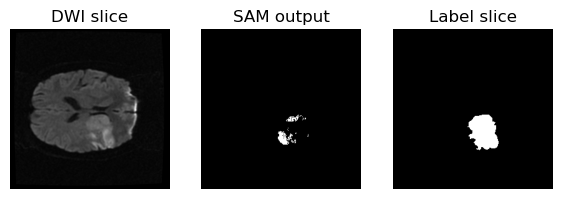

326
Dice for slice: 0.138


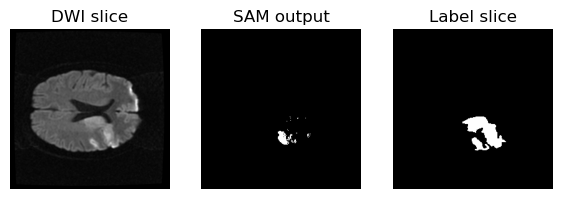

554
Dice for slice: 0.399


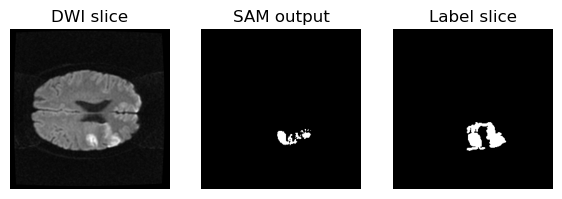

346
Dice for slice: 0.399


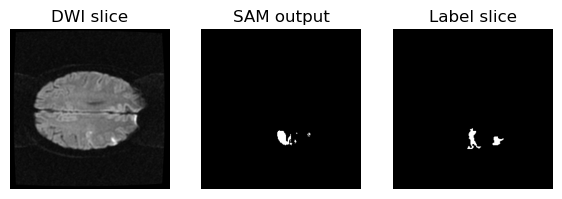

175
Dice for slice: 0.753


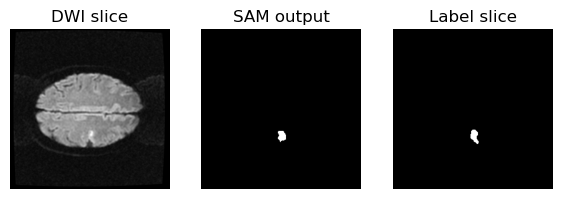

189
Dice for slice: 0.832


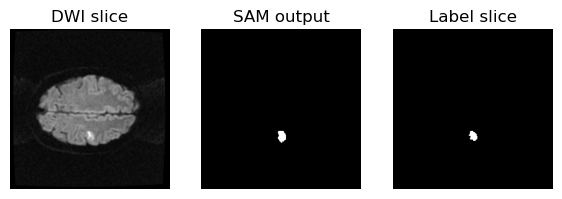

Mean slice dice for subject: 0.466
Volume dice for subject: 0.351
__________________________________
Volume: 5 of 8
Optimizing level 0 [max iter: 0]


100%|██████████| 4/4 [00:16<00:00,  4.02s/it]

28
Dice for slice: 0


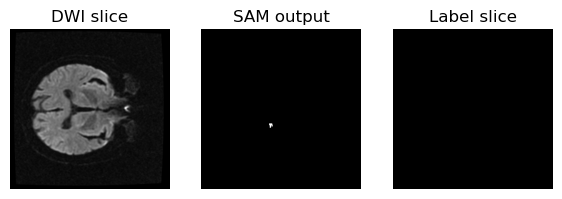

30
Dice for slice: 0.598


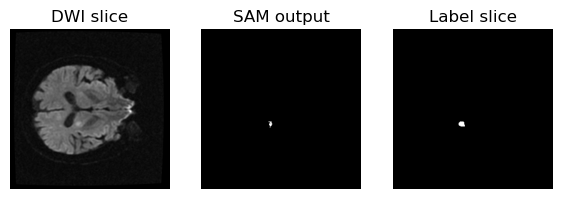

25
Dice for slice: 0.0


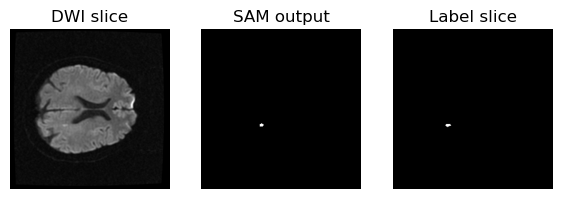

26
Dice for slice: 0.96


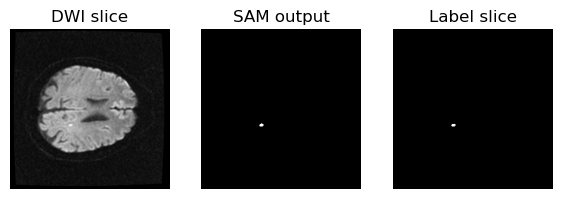

0
Dice for slice: 0.0


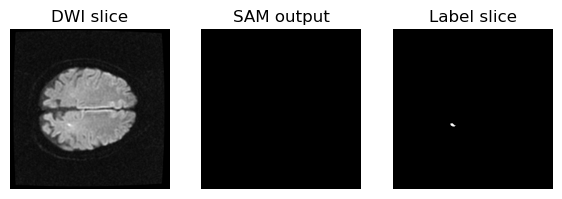

Mean slice dice for subject: 0.312
Volume dice for subject: 0.414
__________________________________
Volume: 6 of 8
Optimizing level 0 [max iter: 0]


100%|██████████| 7/7 [00:24<00:00,  3.51s/it]

122
Dice for slice: 0.324


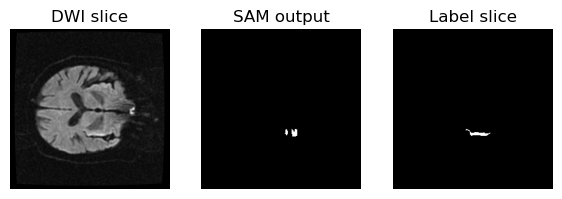

416
Dice for slice: 0.334


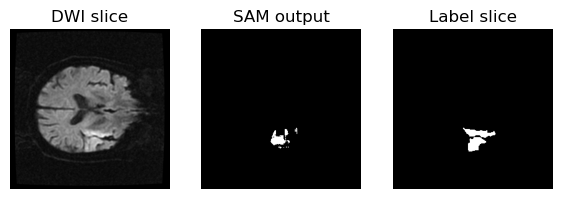

617
Dice for slice: 0.555


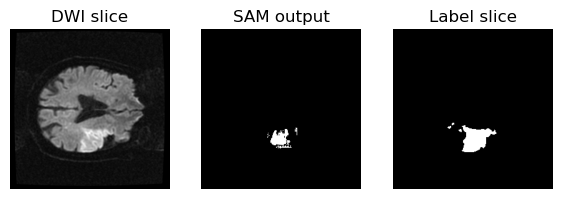

545
Dice for slice: 0.31


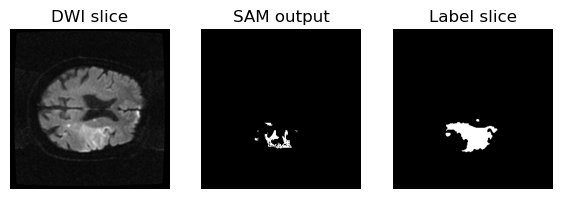

472
Dice for slice: 0.216


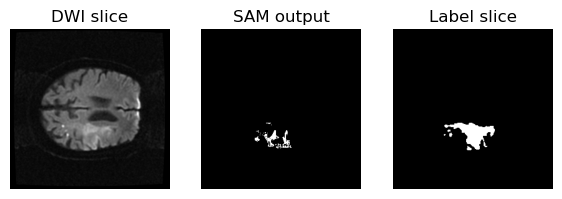

574
Dice for slice: 0.303


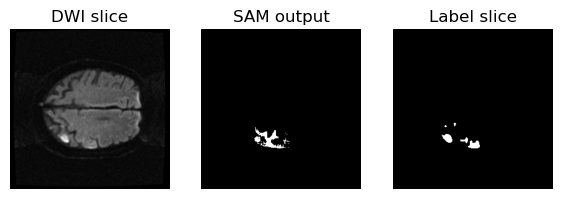

81
Dice for slice: 0.672


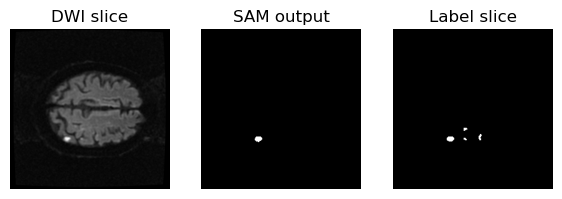

Mean slice dice for subject: 0.388
Volume dice for subject: 0.356
__________________________________
Volume: 7 of 8
Optimizing level 0 [max iter: 0]


100%|██████████| 4/4 [00:12<00:00,  3.04s/it]


55
Dice for slice: 0


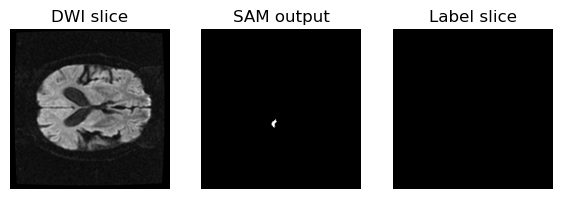

83
Dice for slice: 0.455


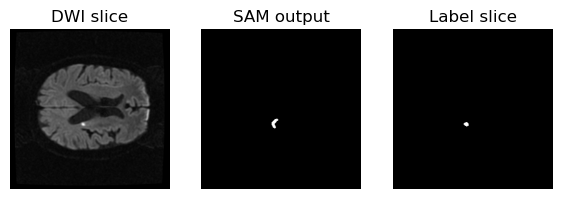

0
Dice for slice: 0.0


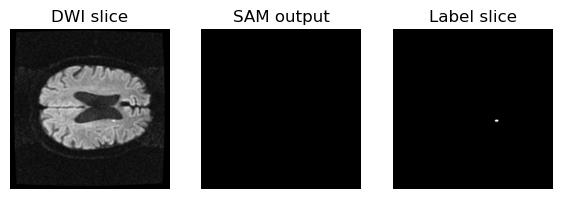

0
Dice for slice: 0.0


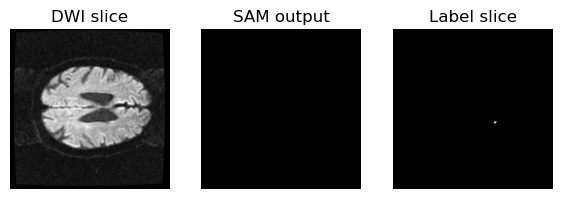

47
Dice for slice: 0.358


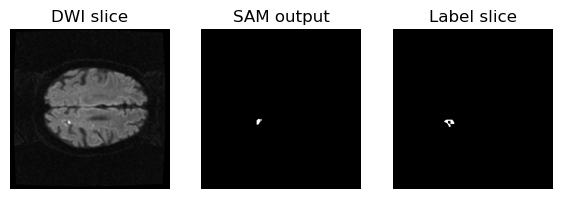

0
Dice for slice: 0.0


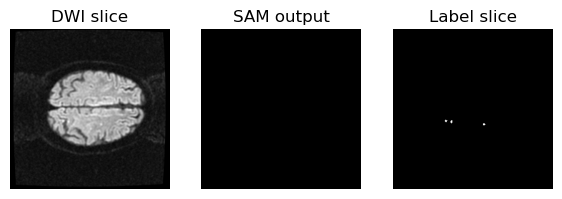

28
Dice for slice: 0.697


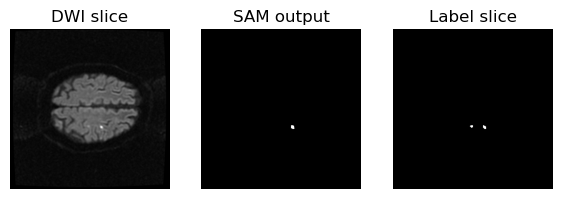

Mean slice dice for subject: 0.216
Volume dice for subject: 0.344
__________________________________
Volume: 8 of 8
Optimizing level 0 [max iter: 0]


100%|██████████| 8/8 [00:28<00:00,  3.51s/it]

78
Dice for slice: 0.52


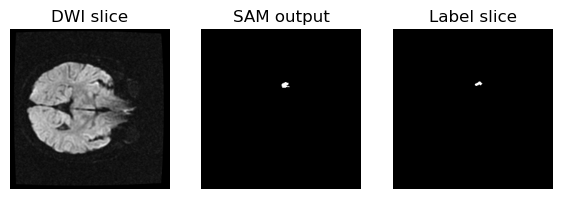

141
Dice for slice: 0.19


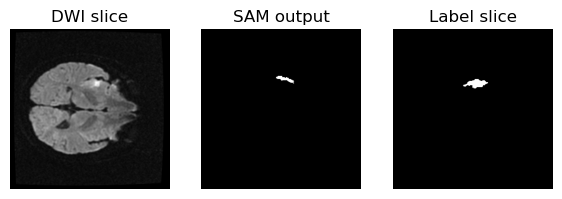

720
Dice for slice: 0.494


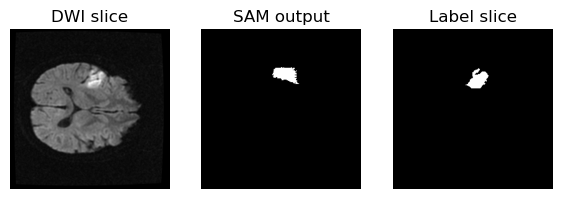

791
Dice for slice: 0.539


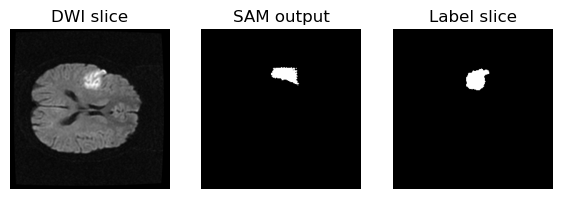

722
Dice for slice: 0.44


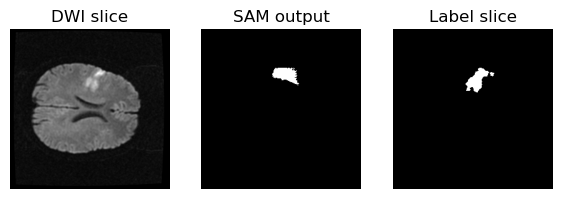

291
Dice for slice: 0.396


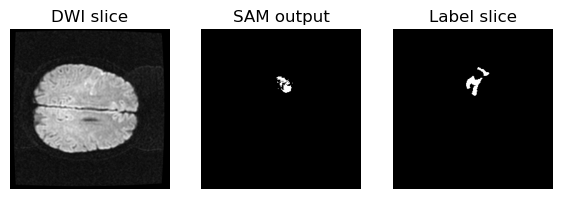

0
Dice for slice: 0.0


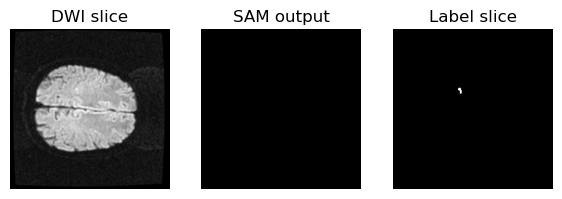

37
Dice for slice: 0.63


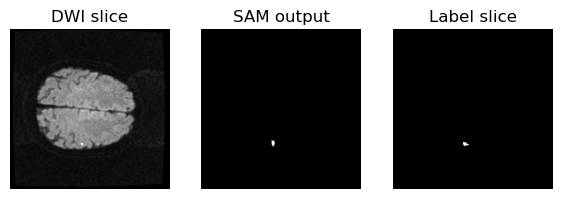

0
Dice for slice: 0.0


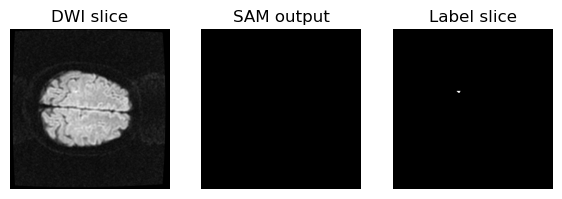

19
Dice for slice: 0.76


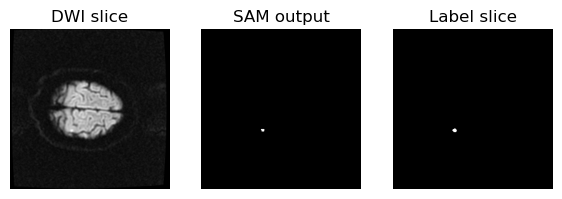

Mean slice dice for subject: 0.397
Volume dice for subject: 0.458
__________________________________
____________________________________________________________________
Mean slice dice for each subject: [0.35996433507648695, 0.34796238244514105, 0.334455228010452, 0.46586376423625153, 0.31158762886597935, 0.38777569961623654, 0.21578045786272942, 0.3968032030509391]
Volume dice for each subject: [0.5516594347367186, 0.5766233766233766, 0.3741082668904742, 0.350864068227725, 0.4140625, 0.35588647890363656, 0.3440366972477064, 0.4577755742852421]

Mean slice dice for all subjects: 0.352524087395527
Mean volume dice for all subjects: 0.42812704961435993


In [11]:
batchSize = 1
type = 'test'
Avg_Dice_subjects = [] #Slice based
Dice_for_subjects = [] #Slice based
Dice_vol_subjects = [] #Volume based
for i in range(0,len(data)):
      print(f'Volume: {i+1} of {len(data)}')
      Dice_slices = []

      # Get the bounding_box to prompt SAM:
      prompt = prompts_from_Unet[i]

      # Get paths to scans and masks for each subject in the datasplit
      DWI_path, ADC_path, b0_path, label_path = data[i]

      # Load data:
      dataset = getVolume(DWI_path, ADC_path, b0_path, label_path, prompt)

      # Load dataset for SAM:
      val_dataset = SAMDataset(dataset = dataset, processor = processor, type = type, prompt = prompt)
      val_dataloader = DataLoader(val_dataset, batch_size = batchSize, shuffle = False, drop_last = False)

      for batch in tqdm(val_dataloader):
            with torch.cuda.amp.autocast():
                  outputs = model(pixel_values=batch["pixel_values"].to(device), input_boxes=batch["input_boxes"].to(device), multimask_output=False)
                  predicted_masks = outputs.pred_masks.squeeze(1)
                  output_volume = np.asarray(torch.squeeze(predicted_masks[0,:,:,:]).cpu().detach()).transpose(1, 2, 0)
            torch.cuda.empty_cache()

      # Dice for volume:
      output_volume = output_volume > 0.5
      Label_vol = nib.load(label_path).get_fdata()
      dice_vol = Find_DICE_vol(output_volume, Label_vol)
      Dice_vol_subjects.append(dice_vol)

      # Loop though each slice:
      DWI_vol = nib.load(DWI_path).get_fdata()
      for i in range (0, len(DWI_vol[0,0,:])):
            DWI_slice = DWI_vol[:,:,i]
            Label_slice = Label_vol[:,:,i]
            model_output = (output_volume[:,:,i])

            if np.sum(Label_slice) > 0 or np.sum(model_output) > 0: # "Empty" slices are not included
                        print(np.sum(model_output))
                        # Dice:
                        dice_slice = Find_DICE_slice(model_output, Label_slice)
                        Dice_slices.append(dice_slice)
                        print('Dice for slice:', round(dice_slice,3))

                        # Plot:
                        plotFunc(DWI_slice, model_output, Label_slice)
        
      Dice_for_subjects.append(Dice_slices)
      Avg_Dice_subjects.append(mean(Dice_slices))
      print('Mean slice dice for subject:', round(mean(Dice_slices),3))
      print('Volume dice for subject:', round(dice_vol,3))
      print('__________________________________')
print('____________________________________________________________________')
print('Mean slice dice for each subject:', Avg_Dice_subjects)
print('Volume dice for each subject:', Dice_vol_subjects)
print('')
print('Mean slice dice for all subjects:', mean(Avg_Dice_subjects))
print('Mean volume dice for all subjects:', mean(Dice_vol_subjects))

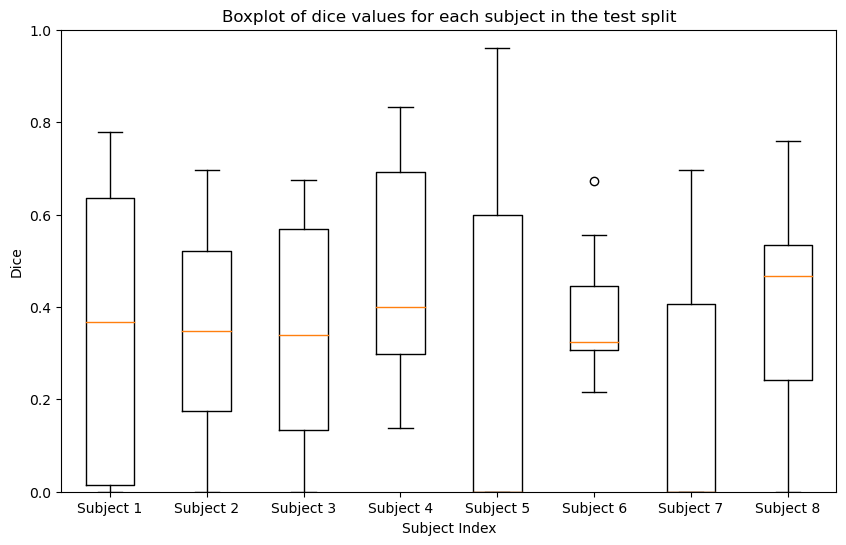

In [12]:
# Example data: a list of lists
data = Dice_for_subjects

# Create a figure and a set of subplots
plt.figure(figsize=(10, 6))

# Create the boxplot
plt.boxplot(data)

# Adding titles and labels
plt.title('Boxplot of dice values for each subject in the test split')
plt.xlabel('Subject Index')
plt.ylabel('Dice')

# Customize x-axis labels if needed
plt.xticks(range(1, len(data) + 1), ['Subject 1', 'Subject 2', 'Subject 3', 'Subject 4', 'Subject 5', 'Subject 6', 'Subject 7', 'Subject 8'])

# Set y-axis limits
plt.ylim(0, 1)

# Show the plot
plt.show()